In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# 1. MNIST train, test dataset 가져오기

In [2]:
mnist_train=dset.MNIST("", train=True, transform=transforms.ToTensor(),
                      target_transform=None, download=True)
mnist_test=dset.MNIST("", train=False, transform=transforms.ToTensor(),
                      target_transform=None, download=True)

# 2. 대략적인 데이터 형태

mnist_train 길이: 60000
mnist_test 길이: 10000
image data 형태: torch.Size([1, 28, 28])
label:  5


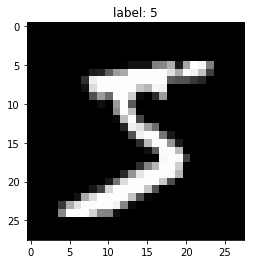

In [3]:
print "mnist_train 길이:", len(mnist_train)
print "mnist_test 길이:", len(mnist_test)

#데이터 하나 형태
image, label = mnist_train.__getitem__(0) #0번째 데이터
print "image data 형태:", image.size()
print "label: ", label

#그리기
img = image.numpy() #numpy 타입으로 변환
plt.title("label: %d" %label)
plt.imshow(img[0], cmap='gray')
plt.show()

# 3. 데이터 로드함수

In [4]:
#hyper parameters
batch_size = 1024
learning_rate = 0.01
num_epoch = 400

In [5]:
train_loader = torch.utils.data.DataLoader(mnist_train,
                                          batch_size=batch_size,
                                          shuffle=True, num_workers=2,
                                          drop_last=True) #나머지 버림
test_loader = torch.utils.data.DataLoader(mnist_test,
                                          batch_size=batch_size,
                                          shuffle=False, num_workers=2,
                                          drop_last=True) #나머지 버림

## 데이터 로드함수 이해하기

[0]
한 번에 로드되는 데이터 크기: 1024


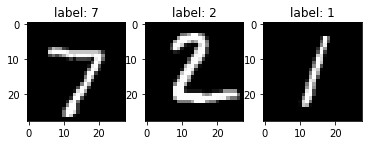

[1]
한 번에 로드되는 데이터 크기: 1024


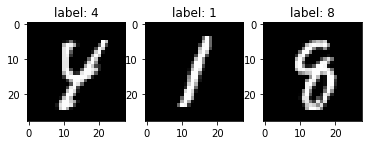

[2]
한 번에 로드되는 데이터 크기: 1024


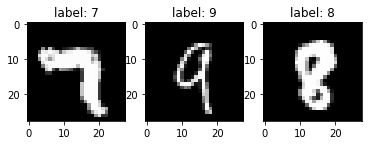

[3]
한 번에 로드되는 데이터 크기: 1024


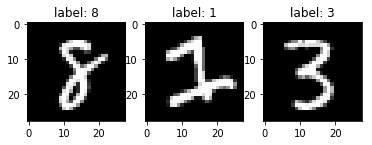

[4]
한 번에 로드되는 데이터 크기: 1024


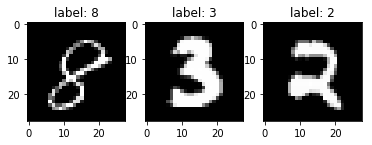

[5]
한 번에 로드되는 데이터 크기: 1024


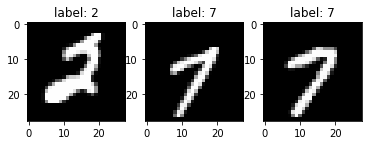

In [7]:
n = 3 #샘플로 그려볼 데이터 개수
for i, [imgs, labels] in enumerate(test_loader):
    if i>5:
        break
        
    print "[%d]" %i
    print "한 번에 로드되는 데이터 크기:", len(imgs)
    
    #그리기
    for j in range(n):
        img = imgs[j].numpy()
        img = img.reshape((img.shape[1], img.shape[2])) #(1,28,28)->(28,28)
        
        plt.subplot(1, n, j+1) #(1,3) 형태 플랏의 j번째 자리에 그리겠다
        plt.imshow(img, cmap='gray')
        plt.title("label: %d" %labels[j])
    plt.show()

# 4. 모델 선언

In [8]:
#퍼셉트론(2 hidden layer)
model = nn.Sequential(
    nn.Linear(28*28,256),
    nn.Sigmoid(),
    nn.Linear(256,128),
    nn.Linear(128,10),
)
# 파라미터 보기
# print(list(model.parameters()))

In [9]:
def ComputeAccr(dloader, imodel):
    correct = 0
    total = 0
    
    for j, [imgs, labels] in enumerate(dloader): #batch_size만큼
        img = imgs #x
        label = Variable(labels) #y
        #label = Variable(labels).cuda()
        #.cuda(): GPU에 로드되기 위함. 만약 CPU로 설정되어 있다면 에러남
        
        #(batch_size, 1, 28, 28) -> (batch_size, 28, 28)
        img = img.reshape((img.shape[0], img.shape[2], img.shape[3]))
        #(batch_size, 1, 28, 28) -> (batch_size, 28*28)
        img = img.reshape((img.shape[0], img.shape[1]*img.shape[2]))
        img = Variable(img, requires_grad=False)
        #img = Variable(img, requires_grad=False).cuda()
        
        output = imodel(img) #forward prop
        _, output_index = torch.max(output, 1)
        
        total += label.size(0)
        correct += (output_index == label).sum().float()
    print("Accuracy of Test Data: {}".format(100*correct/total))


In [10]:
ComputeAccr(test_loader, model)

Accuracy of Test Data: 8.93012142181


# 5. loss, optimizer

In [11]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# 6. 학습

In [12]:
for i in range(num_epoch):
    for j, [imgs, labels] in enumerate(train_loader):
        img = imgs
        label = Variable(labels)
        
        img = img.reshape((img.shape[0], img.shape[2], img.shape[3]))
        img = img.reshape((img.shape[0], img.shape[1]*img.shape[2]))
        img = Variable(img, requires_grad=True)
        
        optimizer.zero_grad()
        output = model(img)
        loss = loss_func(output, label)
        
        loss.backward()
        optimizer.step()
        
    if i%50==0:
        print("%d.." %i)
        ComputeAccr(test_loader, model)
        print loss

0..
Accuracy of Test Data: 12.890625
tensor(2.2948, grad_fn=<NllLossBackward>)
50..
Accuracy of Test Data: 80.4036483765
tensor(0.7367, grad_fn=<NllLossBackward>)
100..
Accuracy of Test Data: 88.0533828735
tensor(0.4179, grad_fn=<NllLossBackward>)
150..
Accuracy of Test Data: 89.74609375
tensor(0.3118, grad_fn=<NllLossBackward>)
200..
Accuracy of Test Data: 90.5815963745
tensor(0.3371, grad_fn=<NllLossBackward>)
250..
Accuracy of Test Data: 91.232635498
tensor(0.3260, grad_fn=<NllLossBackward>)
300..
Accuracy of Test Data: 91.5581588745
tensor(0.3248, grad_fn=<NllLossBackward>)
350..
Accuracy of Test Data: 91.8619766235
tensor(0.3684, grad_fn=<NllLossBackward>)


# 7. 테스트

In [30]:
ComputeAccr(test_loader, model)

Accuracy of Test Data: 91.9921875


# 8. 학습된 파라미터 저장

In [32]:
netname = './nets/mlp_weight.pkl'
torch.save(model, netname, )